# Import Packages

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, average_precision_score, make_scorer, precision_recall_curve, roc_curve
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# Load Data

In [2]:
df = pd.read_csv("../data/prepped_data.csv", low_memory=False, index_col=0).drop_duplicates()

df = df[df["welcome_discount"] == 1]

# Setup Model

In [3]:
print(df.columns)

Index(['policy_nr_hashed', 'welcome_discount', 'last_data_year',
       'first_data_year', 'churn', 'control_group', 'first_premium',
       'last_premium', 'first_split', 'last_split', 'last_customer_age',
       'last_accident_free_years', 'last_car_value', 'last_age_car',
       'last_brand', 'last_type', 'last_weight', 'last_fuel_type',
       'last_postcode', 'last_product', 'last_allrisk basis',
       'last_allrisk compleet', 'last_allrisk royaal', 'last_wa-extra',
       'nr_cars', 'fake_alarm', 'policyholder_change', 'max_nr_coverages',
       'last_nr_coverages', 'last_trend_nr_coverages', 'accident_years',
       'last_year_car_change', 'last_change_premium_abs',
       'last_change_premium_perc', 'years_since_last_car_change',
       'n_last_vs_peak', 'last_vs_first_split', 'lpa',
       'cum_change_premium_abs', 'cum_change_premium_perc'],
      dtype='object')


In [4]:
categorical_features = []
continuous_features = []
binary_features = []

# Define a threshold for the maximum number of unique values for a categorical column
max_unique_values_for_categorical = 10

# Iterate through each column to determine if it's categorical, continuous, or binary
for column in df.columns:
    unique_values = df[column].nunique()
    if unique_values == 2:
        # If exactly 2 unique values, treat column as binary
        binary_features.append(column)
    elif (df[column].dtype == 'object' or unique_values <= max_unique_values_for_categorical) and unique_values > 2:
        # If object type or up to the threshold of unique values (and more than 2), treat as categorical
        categorical_features.append(column)
    else:
        # Otherwise, treat as continuous
        continuous_features.append(column)

categorical_features = [col for col in categorical_features if col != "years_since_last_car_change"]
continuous_features = continuous_features + ["years_since_last_car_change"]

print(f'Binary Features: {binary_features}')
print(f'Categorical Features: {categorical_features}')
print(f'Continuous Features: {continuous_features}')

for cat in categorical_features:
     df[cat] = df[cat].astype("category")

Binary Features: ['churn', 'last_allrisk basis', 'last_allrisk compleet', 'last_allrisk royaal', 'last_wa-extra', 'fake_alarm', 'policyholder_change', 'lpa']
Categorical Features: ['policy_nr_hashed', 'last_data_year', 'control_group', 'last_brand', 'last_type', 'last_fuel_type', 'last_postcode', 'last_product', 'nr_cars', 'max_nr_coverages', 'last_nr_coverages', 'last_trend_nr_coverages', 'last_year_car_change', 'n_last_vs_peak']
Continuous Features: ['welcome_discount', 'first_data_year', 'first_premium', 'last_premium', 'first_split', 'last_split', 'last_customer_age', 'last_accident_free_years', 'last_car_value', 'last_age_car', 'last_weight', 'accident_years', 'last_change_premium_abs', 'last_change_premium_perc', 'last_vs_first_split', 'cum_change_premium_abs', 'cum_change_premium_perc', 'years_since_last_car_change']


In [5]:
# cols_to_drop_manual = ["first_split", "first_premium", "nr_cars", "last_type", "last_brand", 'last_weight', 'n_last_vs_peak', 'last_fuel_type', 'last_trend_nr_coverages', 'last_change_premium_abs', 'last_change_premium_perc', 'max_nr_coverages', 'last_nr_coverages',]
cols_to_drop = ["churn", "policy_nr_hashed", "last_data_year", "first_data_year", "control_group"]
selected_columns = [col for col in df.columns if not any(col.startswith(prefix) for prefix in cols_to_drop)]

X = df[selected_columns]
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# Custom Metric

In [6]:
weights = {
    'TP': 0,  # High importance to correctly identify churners
    'FP': 0,  # Moderate to high cost of misclassifying loyal customers
    'FN': 100.0,   # High cost of missing actual churners
    'TN': 100.0
}

def weighted_cost(y_true, y_scores, weights):

    tn, fp, fn, tp = confusion_matrix(y_true, y_scores).ravel()

    # Weight everyone
    TP_wght = tp * weights['TP']
    FP_wght = fp * weights['FP']
    FN_wght = fn * weights['FN']
    TN_wght = tn * weights['TN']

    # Compute weighted cost and normalise
    wghtd_cost = TP_wght + FP_wght + FN_wght + TN_wght

    return -wghtd_cost

weighted_cost_scorer = make_scorer(weighted_cost, needs_proba=True, weights=weights)

# Model Selection

In [13]:
space = {
    'max_depth': hp.uniformint('max_depth', 50, 101),
    'num_leaves': hp.uniformint('num_leaves', 2, 201),
    'min_child_samples': hp.uniformint('min_child_samples', 7, 101),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.25, 1),
    'subsample': hp.uniform('subsample', 0.25, 1),
    'subsample_freq': hp.uniformint('subsample_freq', 1, 100),
    'reg_alpha': hp.uniform('reg_alpha', 0, 0.2),
    'reg_lambda': hp.uniform('reg_lambda', 0, 0.2),
    'min_split_gain': hp.uniform('min_split_gain', 0, 0.5),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
    'min_data_in_leaf': hp.uniformint('min_data_in_leaf', 1, 21)
}

def objective(params):
    clf = lgb.LGBMClassifier(
        objective='binary',
        force_row_wise=True,
        verbosity=-1,
        n_estimators=50,
        # is_unbalance=True,
        **params
    )
    score = cross_val_score(clf, X_train, y_train, cv=5, scoring="average_precision").mean()
    return {'loss': -score, 'status': STATUS_OK}

n_iter = 50
trials = Trials()

best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=n_iter, trials=trials, rstate=np.random.RandomState(0))

print("Best Score is: ", -trials.best_trial['result']['loss'])
print("Best Parameters: ", best)

100%|██████████| 50/50 [02:09<00:00,  2.58s/trial, best loss: -0.7293330836499031]
Best Score is:  0.7293330836499031
Best Parameters:  {'colsample_bytree': 0.7797842550562021, 'learning_rate': 0.07427987307455988, 'max_depth': 101.0, 'min_child_samples': 25.0, 'min_data_in_leaf': 3.0, 'min_split_gain': 0.01062425976332533, 'num_leaves': 135.0, 'reg_alpha': 0.1477088464594706, 'reg_lambda': 0.19918141618101032, 'subsample': 0.9157039094500589, 'subsample_freq': 18.0}


In [296]:
best_params = {
    'max_depth': int(best['max_depth']),
    'num_leaves': int(best['num_leaves']),
    'min_child_samples': int(best['min_child_samples']),
    'colsample_bytree': best['colsample_bytree'],
    'subsample': best['subsample'],
    'subsample_freq': int(best['subsample_freq']),
    'reg_alpha': best['reg_alpha'],
    'reg_lambda': best['reg_lambda'],
    'min_split_gain': best['min_split_gain'],
    'learning_rate': best['learning_rate'],
    'min_data_in_leaf': int(best['min_data_in_leaf'])
}

lgbm_best = lgb.LGBMClassifier(
    objective='binary',
    force_row_wise=True,
    verbosity=-1,
    n_estimators=50,
    is_unbalance=True,
    **best_params
)

# Validation

In [297]:
scores_f1 = cross_val_score(lgbm_best, X, y, cv=5, scoring="f1")
scores_auc_pr = cross_val_score(lgbm_best, X, y, cv=5, scoring='average_precision')
scores_auc_roc = cross_val_score(lgbm_best, X, y, cv=5, scoring='roc_auc')
# scores_custom = cross_val_score(lgbm_best, X, y, cv=5, scoring=weighted_cost_scorer)

print('CV Average F1 score: {0:0.4f}'.format(np.mean(scores_f1)))
print('CV Average AUC-PR score: {0:0.4f}'.format(np.mean(scores_auc_pr)))
print('CV Average AUC-ROC score: {0:0.4f}'.format(np.mean(scores_auc_roc)))
# print('CV Average Custom score: {0:0.4f}'.format(np.mean(scores_custom)))

CV Average F1 score: 0.6430
CV Average AUC-PR score: 0.7247
CV Average AUC-ROC score: 0.8656


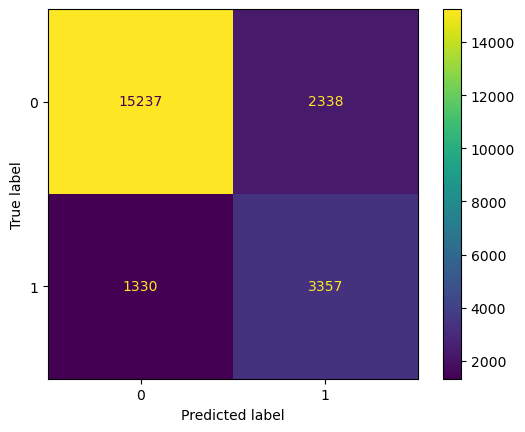

In [298]:
lgbm_best.fit(X_train, y_train)

threshold = 0.5
probabilities = lgbm_best.predict_proba(X_test)[:, 1]
y_pred = np.abs(np.ceil(np.array(probabilities) - threshold)).astype("int")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgbm_best.classes_)
disp.plot()
plt.show()